# Hybrid Model Using LSTM and Exponential Smoothing (ES)

In this model, I make predictions using both the LSTM and ES model, which will be combined at the end to make a hybrid model. This is just an initial exploratory model, it can be fine tuned even more.
- ES captures long-term trends & seasonality.
- LSTM detects short-term fluctuations & complex dependencies.

By integrating these two models, we aim to enhance predictive accuracy.  

## Model Customization Possibilities
This hybrid approach is highly flexible, with several modifiable factors:
Feature Engineering:  
   - Can incorporate additional data sources such as weather, traffic, holidays, and special events.  
LSTM Training Variables:
   - Optimize batch sizes, sequence lengths, epochs, etc
Alternative Baseline Models:
   - We can also swap Exponential Smoothing for Prophet, ARIMA, or other stable forecasting models.  

## References and Further Reading
Here are some key papers and articles discussing LTSMs and Hybrid Forcasting as well:
1. [Different LSTM Models](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)
2. [Predicting Stock Market Bubbles: Insights from Deep Learning Models](https://medium.com/@zhonghong9998/predicting-stock-market-bubbles-insights-from-deep-learning-models-7998c585425a)  
   - Covers hybrid modeling with ARIMA and LSTM.
   - Gives good basic examples of how to combine the models  
2. [A Hybrid Residual Dilated LSTM and Exponential Smoothing Model for Midterm Electric Load Forecasting](https://ieeexplore.ieee.org/document/9316921)  
   - Explores combining LSTM & ES for energy demand prediction.  


In [75]:
import pandas as pd

def prepare_dataframe(file_path, time_step="h"):
    """
    Prepare the dataframe for the by resampling the data to the given time_step.
    The data can be split into hourly ("h") and daily ("d") intervals.
    """
    df = pd.read_csv(file_path)

    # Code from Ryan to prepare data to datetime and prepare correct formatting
    df.drop(columns=['Unique ID', 'Nature Code', 'State Plane Feet X',
                     'State Plane Feet Y', 'Shift', 'Battalion', 'Division',
                     'DispatchNature'], inplace=True)
    df['e'] = 1
    filtered_df = df[df['CauseCategory'] == 'EMS'].copy()
    filtered_df['Dispatched'] = pd.to_datetime(
        filtered_df['Dispatched'],
        format='%m/%d/%Y %H:%M'
        )

    # Set datetime as index then resample in intervals of time_step
    filtered_df.set_index('Dispatched', inplace=True)
    df_resampled = filtered_df.resample(time_step).size().to_frame(
        name="call_count"
        )

    return df_resampled

## Function to fit the ES model
- Modular and takes in all parameters that can be used to tweak the model.
- From previous hypertraining, I selected the best performing parameters, trend="mul", seasonal="add", and seasonal_periods=168 (weekly)

In [76]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def fit_es_model(train_data, trend="mul", seasonal="add", seasonal_periods=168):
    """
    Fit an Exponential Smoothing model to the given training data.
    The model can be configured with the following parameters:
    - trend: "add" or "mul" or None
    - seasonal: "add" or "mul" or None
    - seasonal_periods: int
    """
    es_model = ExponentialSmoothing(
        train_data["call_count"],
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods
        ).fit()
    return es_model

## Function to fit the LSTM model
- Modular and takes in parameters that can be modified to improve efficiency or depth
    - sequence_length
    - epochs
    - batch_size
    - scaled_training data (This data is scaled because LSTM models work way better with data with smaller  [MinMaxScaler for LSTMs](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/))

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


def fit_lstm_model(scaled_training_data, sequence_length=24, epochs=10, batch_size=32):
    """
    Fit an LSTM model to the scaled training data. 
    This model can be configured with the following parameters:
    - sequence_length: int
    - epochs: int
    - batch_size: int
    """
    model = Sequential([
        Input(shape=(sequence_length, 1)),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Create sequences using TimeseriesGenerator
    # The input data should be the "scaled_call_count" column
    # The target data should be the same column, shifted by sequence_length
    train_values = scaled_training_data["scaled_call_count"].values
    generator = TimeseriesGenerator(
        train_values,  
        train_values, 
        length=sequence_length,
        batch_size=batch_size
    )

    model.fit(generator, epochs=epochs, verbose=1)
    return model


## Start of Main Function to Create Hybrid Model
### Step 1: Set Global Variables & Prepare Data

- Define key parameters for the LSTM model (sequence length, epochs, batch size).
- Load the dataset and process it into a DataFrame.
- Split the data into training (80%) and testing (20%) sets.
- Normalize the call count values using MinMaxScaler (for LSTM training).

Paramters that can be changed:
- sequence_length: Number of time steps to look back for the LSTM model
- epochs: Number of epochs to train the LSTM model
- batch_size: Batch size for training the LSTM model
- file_path: Path to the raw dataset
- time_step: Time sections that the data will be trained on. Use "h" for hourly, "d" for daily

In [78]:
from sklearn.preprocessing import MinMaxScaler

# Varables to update the LSTM model
sequence_length = 24
epochs = 10
batch_size = 32
file_path = "../../../CLT_data.csv"   
time_step = "h"

# Prepare the dataframe calling prepare_dataframe function
df = prepare_dataframe(file_path, time_step)

# Split the data into training and testing sets
split_index = int(len(df) * 0.8)  
training_data = df.iloc[:split_index].copy()
testing_data = df.iloc[split_index:].copy()

# Scale the training data using MinMaxScaler for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
training_data["scaled_call_count"] = scaler.fit_transform(training_data[["call_count"]])
testing_data["scaled_call_count"] = scaler.transform(testing_data[["call_count"]])


### Step 2: Train Exponential Smoothing (ES) Model
- Train the Holt-Winters Exponential Smoothing model on the training data.
- Define trend (`add`), seasonality (`add`), and seasonal periods (`168` for weekly cycles).
- Forecast ES model predictions on the test dataset and save them into the dataframe.

In [85]:
# Fit the ES model
es_model = fit_es_model(training_data, trend="add", seasonal="add", seasonal_periods=168)

# Make predictions using the ES model
es_forcast = es_model.forecast(steps=len(testing_data))

# Store the predictions in the testing_data DataFrame
testing_data["es_forecast"] = es_forcast

### Step 3: Train LSTM Model
- Build an LSTM model with:
  - 2 LSTM layers
  - Dropout layer (0.2) to reduce overfitting
  - Dense output layer
- Train the model on the scaled training set
- Use the trained LSTM to forecast on the test dataset

In [80]:
# Fit the LSTM model
lstm_model = fit_lstm_model(training_data, sequence_length=sequence_length, epochs=epochs, batch_size=batch_size)

# We create a new generator for the testing data to make predictions
test_values = testing_data["scaled_call_count"].values

# Test values 
test_generator = TimeseriesGenerator(
    test_values,
    test_values,
    length=sequence_length,
    batch_size=1
)

# Make predictions using the LSTM model
lstm_forecast = lstm_model.predict(test_generator)

# Before storing the predictions in the testing_data dataframe, we need to inverse the scaling
lstm_forecast = scaler.inverse_transform(lstm_forecast).flatten()

# The testing_data dataframe has an extra sequence_length rows at the beginning so we need
# to remove it by slcing the original testing_data dataframe.
testing_data = testing_data.iloc[sequence_length:]

# Store predictions in the testing_data dataframe
testing_data["lstm_forecast"] = lstm_forecast


Epoch 1/10


c:\Users\Evan Liu\Documents\portfolio project\CS476\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1315/1315 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0113
Epoch 2/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0084
Epoch 3/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 0.0084
Epoch 4/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0083
Epoch 5/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 0.0084
Epoch 6/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0083
Epoch 7/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0085
Epoch 8/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0083
Epoch 9/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0081
Epoch 10/10
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0083
10498/10498 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step


### Step 4: Combine ES + LSTM Predictions
- Use a weighted combination of ES and LSTM forecasts to make a final 
- Adjust weights based on model performance.

In [81]:

# Combine the ES and LSTM forecasts into a forecast
testing_data["hybrid_forecast"] = 0.2 * testing_data["es_forecast"] + 0.8 * testing_data["lstm_forecast"]

### Step 5: Evaluate the Hybrid Model
- Compare the **Mean Absolute Error (MAE) for:
  - ES Model
  - LSTM Model
  - Hybrid ES/LSTM Model
- Print the results to see which model performs best.
- Plot each prediction as well

ES MAE: 5.7775493608702355
LSTM MAE: 2.578152085649647
Hybrid MAE: 2.523642634453539


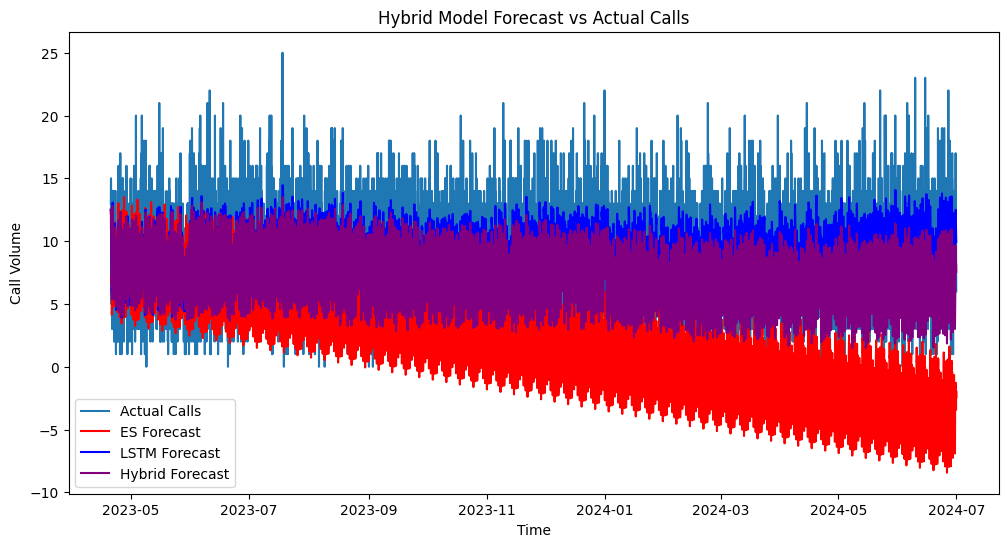

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Calculate the MAE for both models
es_mae = mean_absolute_error(testing_data["call_count"], testing_data["es_forecast"])
lstm_mae = mean_absolute_error(testing_data["call_count"], testing_data["lstm_forecast"])
hybrid_mae = mean_absolute_error(testing_data["call_count"], testing_data["hybrid_forecast"])
print(f"ES MAE: {es_mae}\nLSTM MAE: {lstm_mae}\nHybrid MAE: {hybrid_mae}")

plt.figure(figsize=(12, 6))
plt.plot(testing_data.index, testing_data["call_count"], label="Actual Calls")
plt.plot(testing_data.index, testing_data["es_forecast"], label="ES Forecast", linestyle="solid", color="red")
plt.plot(testing_data.index, testing_data["lstm_forecast"], label="LSTM Forecast", linestyle="solid", color="blue")
plt.plot(testing_data.index, testing_data["hybrid_forecast"], label="Hybrid Forecast", linestyle="solid", color="purple")
plt.legend()
plt.title("Hybrid Model Forecast vs Actual Calls")
plt.xlabel("Time")
plt.ylabel("Call Volume")
plt.show()
